![A7 Header](A7.jpg)

<h1 style="font-family:Arial;color:#333399"> Empirical analysis of cash rates benchmark hedging </h1>

<p style="color:#333333;font-family:Arial">
This article is designed to demonstrate the effectiveness of A7 API and how it can be used to solve a practical use case.</p>

<p style="color:#333333;font-family:Arial">
This use case is a simplistic approach where we examine the liquidity profile of a futures contract to analyze the cost of hedging a large clip EGB/SSA trade. For this article we define large sized trades as being transactions that are larger than the top of the book (TOB) for the closest duration futures contract.</p>

<p style="color:#333333;font-family:Arial">
For example what would be the cost to hedge EUR25M German 10Y benchmark bond using FGBL. The main tactical short term hedging strategy employed for cash rates (e.g. EGB, EUR IRS and EUR SSA) has historically been EUREX fixed income futures contracts. Additionally for (EUR) SSA bond, using futures contracts can be a cheaper option than using IRS or Government Bonds.    
</p>

<p style="color:#333333;font-family:Arial">
From a practical perspective there are strategies available to transact large trades which are hedged with futures contracts and would not require stepping down the order book ladder (e.g. Block trades, EGB basis market). However in some cases (e.g. RFQ style trading strategy) transactions in cash rates instruments will be executed solely as single instruments and hence would require hedging using the order book.    
</p>

<p style="color:#333333;font-family:Arial">
An extension of this use case would be to incorporate this measure into pre-trade metrics which can be used to justify a trading strategy (e.g. VWAP instead of a single large clip) or to incorporate into real time metrics to indicate as a liquidity measure. 
</p>

<p style="color:#333333;font-family:Arial">
One assumption which can be challenged is that the TOB is an accurate representation of the price of a futures contract. More accurately it is a price based on the quoted size (number of contracts). A similar style of assumption can be applied to RFQ markets, in the style of composite prices. As with the order book, composites are conditional on size. For example if the average size quoted is for 5M then the composite might not be a good representation of a price for larger sized trades. There are several factors that can influence larger clip bond prices however the following approach can provide a crude indication as to the additional cost of larger size transaction (given that the underlying bond has abundant liquidity and a benign funding market).  
</p>

<p style="color:#333333;font-family:Arial">
For this article the cost is measured as a delta between the top of the book (price level) and the volume weighted average price conditioned on the number of contracts. To test the impact of liquidity on the depth of the order book we have analyzed two periods during 5-June-2020. The first period was a low volatility (10:30) and the second period was during NFP announcement.           
</p>

<p style="color:#333333;font-family:Arial">
To start the investigation we need to set up A7 to extract data. For this users will need to generate an API token which can obtained from A7 UI.            
</p>

In [1]:
import requests
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

proxies = {
"http":  "", #Insert http proxy
"https": "", #Insert https proxy
}

API_TOKEN="Bearer XXXXX" #Insert API token

<p style="color:#333333;font-family:Arial">
The following is a parameter list which contains input details regarding the instrument, market segment and a date. Also note that a user needs to be provided with an algorithm. Please consult the pervious use case examples on how to extract reference data (e.g. Market segment and instrument ID).    
</p>

In [13]:
params = {
    'host': 'https://a7.deutsche-boerse.com/api/v1',
    'algo_user':'XXXX', #Insert user
    'algo':'PriceLevelv2',
    'day':'20200605',
    'marketID':'XEUR',
    'marketSegmentID':'688',
    'securityID':'4611674'
}

<h2 style="font-family:Arial;color:#333399">A7 Data Extraction</h2>

<p style="color:#333333;font-family:Arial">
In this section we extract data based on the parameter list above. The following segment of code extracts the top 10 layers of an order book for a given day. This requires the use of an A7 algorithm (PriceLevelv2). This approach offers flexibility in customizing the depth of the order book. In this case a depth of 10 layers should be adequate for the analysis.             
</p>

In [14]:
ts,pv,sz,ob,lv = [],[],[],[],[]
orderbook_levels=list(range(1,16))
for x in orderbook_levels:
    url = "{host}/algo/{algo_user}/{algo}/run?marketId={marketID}&date={day}&marketSegmentId={marketSegmentID}&securityId={securityID}&Level=".format(**params)    
    url =url + str(x)
    r = requests.get(url = url,  headers={'Authorization': API_TOKEN}, proxies = proxies)
    res = r.json()
    ts_t = res[0]['series'][0]['content']['TS']
    ts = ts + ts_t 
    pv = pv + res[0]['series'][0]['content']['Price']
    sz = sz + res[0]['series'][0]['content']['Qty']
    lv = lv + [x]*len(ts_t)

df_b = pd.DataFrame()
df_b = df_b.assign(ts=ts)
df_b = df_b.assign(pv=pv)
df_b = df_b.assign(sz=sz)
df_b = df_b.assign(lv=lv)
df_b['pv']=df_b['pv'].astype(float)/1e8
df_b['sz']=df_b['sz'].astype(float)/1e4
df_b = df_b.dropna()
df_b['ts'] = df_b['ts'].astype(np.int64)
df_b['ts'] = pd.to_datetime(df_b['ts'])

<p style="color:#333333;font-family:Arial">
Let's examine the populated data frame.           
</p>

In [15]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1752574 entries, 0 to 1752573
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ts      datetime64[ns]
 1   pv      float64       
 2   sz      float64       
 3   lv      int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 66.9 MB


<p style="color:#333333;font-family:Arial">
The following function builds an order book snap shot based on input time parameters and raw order book data. Hence for a given time series the order book price and quantity is provided up to 10 layers deep.             
</p>

In [16]:
def build_snap_shot(df_b,t_1,t_2,t_th):
    cond_t = (df_b['ts']>= t_th) & ((df_b['ts']<=t_2))
    df_t = df_b[cond_t]
    df_t = df_t.sort_values('ts')
    cond = (df_t['ts']>=t_1) & (df_t['ts']<=t_2)
    uq_t = df_t[cond]['ts'].unique()
    pr_v, lv, ts_v, qty  = [],[],[],[]
    for t_v in uq_t:
        for i in orderbook_levels:
            cond = (df_t['ts']<=t_v) & (df_t['lv']==i)
            tmp_pd = df_t[cond]
            pr_v.append(tmp_pd['pv'].iloc[-1])
            lv.append(i) #Note :: Overkill
            ts_v.append(t_v)
            qty.append(tmp_pd['sz'].iloc[-1])
            
    df_snap_s = pd.DataFrame()
    df_snap_s  = df_snap_s.assign(ts=ts_v)
    df_snap_s  = df_snap_s.assign(pr=pr_v)
    df_snap_s  = df_snap_s.assign(qty=qty)
    df_snap_s  = df_snap_s.assign(lv=lv)
    return [df_snap_s,uq_t]

<p style="color:#333333;font-family:Arial">
The following is building an order book snap shot for two time segments. Please note that this is an expensive call (this call can be optimized by redesigning build_snap_shot function).              
</p>

In [17]:
t_1l = datetime.datetime(2020, 6, 5, 10, 29, 00)
t_2l = datetime.datetime(2020, 6, 5, 10, 32, 00)
t_th = datetime.datetime(2020, 6, 5, 10, 20, 00)    
[df_ss_l,uq_tl] = build_snap_shot(df_b,t_1l,t_2l,t_th)

In [18]:
t_1h = datetime.datetime(2020, 6, 5, 12, 29, 45)
t_2h = datetime.datetime(2020, 6, 5, 12, 31, 15)
t_th = datetime.datetime(2020, 6, 5, 12, 25, 00)    
[df_ss_h,uq_th] = build_snap_shot(df_b,t_1h,t_2h,t_th)

In [19]:
def ob_depth_cal(sze,obp,obz):
    '''OB: Return OB volume weighted price, given depth'''
    sze_sum = sze
    p = 0 
    for indx in range(len(obp)):
        if sze_sum >= obz[indx]:
            p = p + obz[indx] * obp[indx]     
            sze_sum  = sze_sum - obz[indx]
        else:
            p = p + sze_sum*obp[indx]
            break     
    return p/sze

<p style="color:#333333;font-family:Arial">
The function above is a simple implementation to compute VWAP based on the depth of an order book. And the following implementation is to compute the VWAP for a collection of clip sizes.            
</p>

In [25]:
def build_hedge_profile(df_snap_s, uq_t):
    h_sz =[150,250,500]
    cols_nmes = [str(y)+'_'+str(x) for x in h_sz  for y in ['b','bd']]
    cols_nmes = ['ts','tb']+cols_nmes  
    rs = pd.DataFrame(columns=cols_nmes)
    for t_v in uq_t:
        ob_sg = df_snap_s[df_snap_s['ts']==t_v]         
        tbb = ob_sg['pr'].iloc[0]
        rs_lst=[]    
        for indx in h_sz:
            b = ob_depth_cal(indx,ob_sg['pr'].to_numpy(),ob_sg['qty'].to_numpy())
            rs_lst.append(b)
            d_b = tbb - b
            rs_lst.append(d_b)
        rs_lst =[t_v,tbb]+rs_lst    
        sliceData = pd.Series(rs_lst,cols_nmes)
        rs = rs.append(sliceData, ignore_index= True)     
    return rs

In [26]:
rs_0 = build_hedge_profile(df_ss_l,uq_tl)

<p style="color:#333333;font-family:Arial">
An interesting point to note is that for the above function call the time to execute is significantly lower than for the following function call. This can be explained by the number of order book updates for the second period. Which is covering non-farm payrolls and is a period of increased volatility.    
</p>

In [27]:
rs_1 = build_hedge_profile(df_ss_h, uq_th)

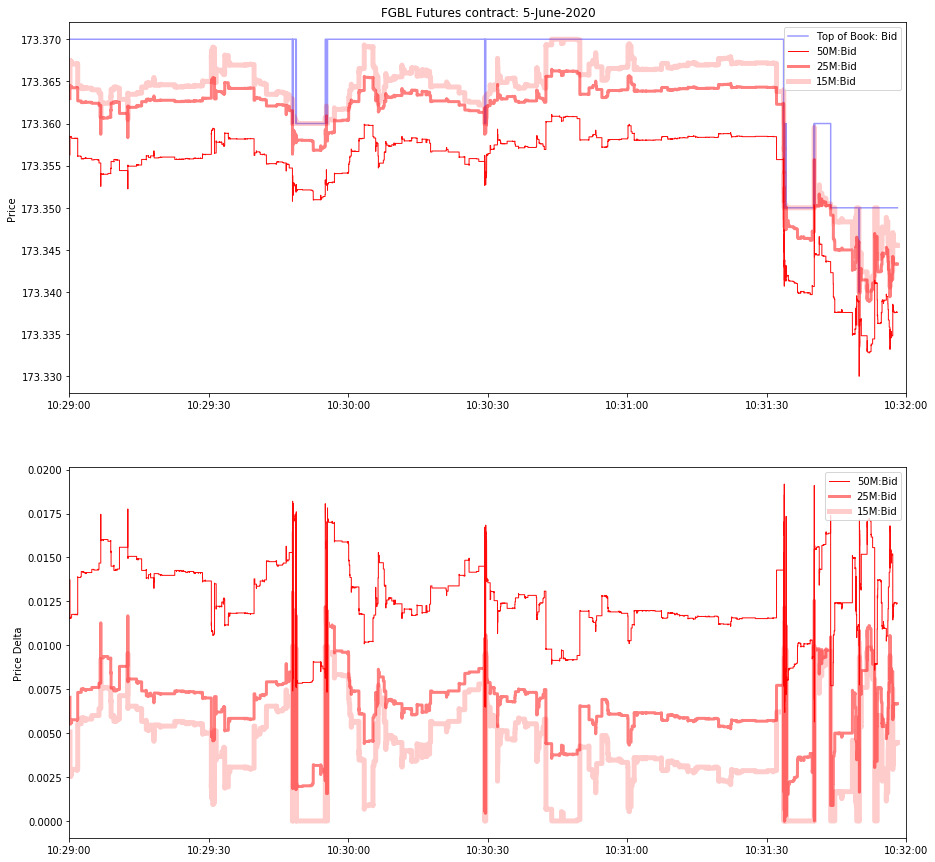

In [31]:
fig, axs = plt.subplots(2, figsize=(15,15))

axs[0].step(rs_0['ts'],rs_0['tb'],color='blue', alpha=0.4, label='Top of Book: Bid')
axs[0].step(rs_0['ts'],rs_0['b_500'],color='red',  alpha=0.95, linewidth=1.0, label='50M:Bid')
axs[0].step(rs_0['ts'],rs_0['b_250'],color='red',  alpha=0.5, linewidth=3.0, label='25M:Bid')
axs[0].step(rs_0['ts'],rs_0['b_150'],color='red',  alpha=0.2, linewidth=5.0, label='15M:Bid')
axs[0].set_ylabel('Price')
axs[0].set_xlim([t_1l,t_2l])
axs[0].set_title('FGBL Futures contract: 5-June-2020')
axs[0].ticklabel_format(useOffset=False, axis='y')
axs[0].legend(loc='upper right')

axs[1].step(rs_0['ts'],rs_0['bd_500'],color='red',  alpha=0.95, linewidth=1.0, label='50M:Bid')
axs[1].step(rs_0['ts'],rs_0['bd_250'],color='red',  alpha=0.5, linewidth=3.0, label='25M:Bid')
axs[1].step(rs_0['ts'],rs_0['bd_150'],color='red',  alpha=0.2, linewidth=5.0, label='15M:Bid')
axs[1].set_ylabel('Price Delta')
axs[1].set_xlim([t_1l,t_2l])
axs[1].legend(loc='upper right')
plt.show()

<p style="color:#333333;font-family:Arial">
The above chart is for a low volatility period and it seems that the cost of hedging higher clips is not significant. However the following is a period of higher market volatility and as the chart indicates the cost of hedging increases significantly.            
</p>

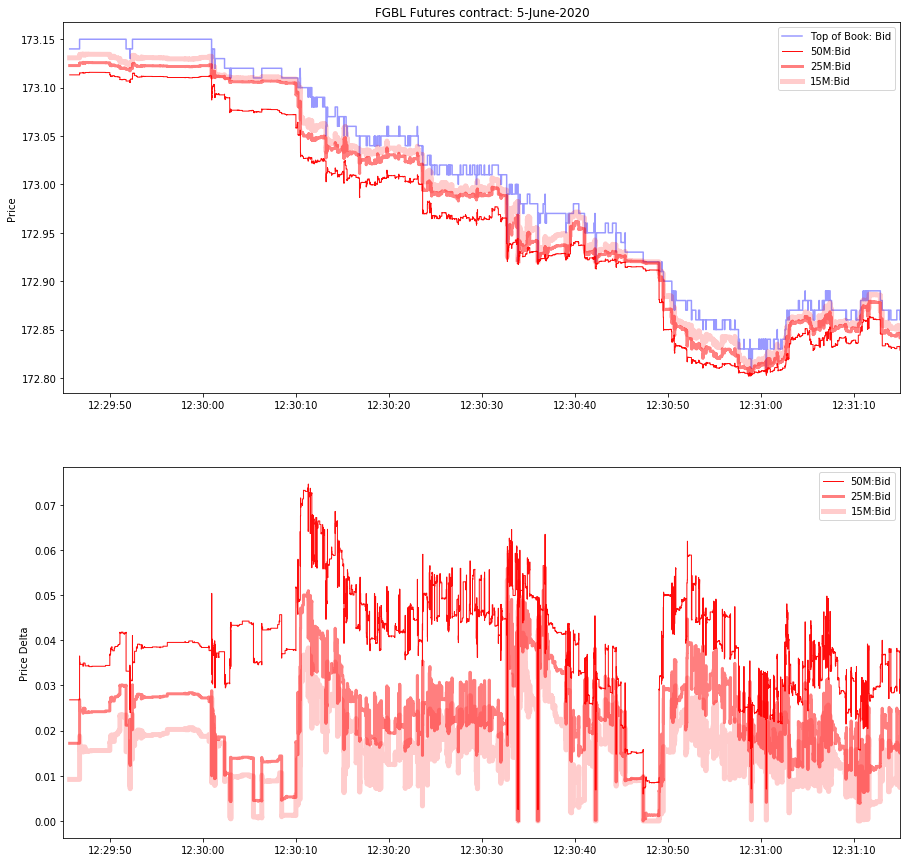

In [32]:
fig, axs = plt.subplots(2, figsize=(15,15))
axs[0].step(rs_1['ts'],rs_1['tb'],color='blue', alpha=0.4, label='Top of Book: Bid')
axs[0].step(rs_1['ts'],rs_1['b_500'],color='red',  alpha=0.95, linewidth=1.0, label='50M:Bid')
axs[0].step(rs_1['ts'],rs_1['b_250'],color='red',  alpha=0.5, linewidth=3.0, label='25M:Bid')
axs[0].step(rs_1['ts'],rs_1['b_150'],color='red',  alpha=0.2, linewidth=5.0, label='15M:Bid')
axs[0].set_ylabel('Price')
axs[0].set_xlim([t_1h,t_2h])
axs[0].set_title('FGBL Futures contract: 5-June-2020')
axs[0].ticklabel_format(useOffset=False, axis='y')
axs[0].legend(loc='upper right')

axs[1].step(rs_1['ts'],rs_1['bd_500'],color='red',  alpha=0.95, linewidth=1.0, label='50M:Bid')
axs[1].step(rs_1['ts'],rs_1['bd_250'],color='red',  alpha=0.5, linewidth=3.0, label='25M:Bid')
axs[1].step(rs_1['ts'],rs_1['bd_150'],color='red',  alpha=0.2, linewidth=5.0, label='15M:Bid')
axs[1].set_ylabel('Price Delta')
axs[1].set_xlim([t_1h,t_2h])
axs[1].legend(loc='upper right')
plt.show()

<p style="color:#333333;font-family:Arial">
This leads to an interesting hypothesis. How much market intelligence can be captured by computing a metric based on order book density. Density is defined as mass divided by volume. In this case volume would be the volume under the surface of TOP size and price level.         
</p>

<h2 style="font-family:Arial;color:#333399">A7 Application</h2>

<p style="color:#333333;font-family:Arial">
Using A7 the local time series for the above segments can be visualized. Additionally, A7 provides the full order book at a granular level. This allows the user to observe a three-dimensional view of the order book. 
    
Below is a grab from A7 for the first market segment. Here we can see the depth of the order book, and the trades executed within this time period. A valuable feature of A7 is the hover functionality which allows users to observe executed price with size. This feature is particularly valuable in that it visually displays aggressive orders and possibly can indicate market move implied by a cluster of aggressive orders.
</p>

![Orderbook chart 1](images/03_figure_1.png)

<p style="color:#333333;font-family:Arial">
The following chart is an A7 grab for the period where NFP was published. As the chart shows there is heightened trading activity across this period. Interestingly there seems to be aggressive selling leading up to the number. A7 allows users to zoom in further into mixed trading activity to isolate buyers and sellers. 
</p>

![Orderbook chart 2](images/03_figure_2.png)

<h2 style="font-family:Arial;color:#333399">Author: Adel Humayun</h2>